In [1]:
import sys
sys.path.append('..//')

import jax
import jax.numpy as jnp
import numpy as np
import pytest
from functools import partial

from parsmooth._base import MVNStandard, FunctionalModel, MVNSqrt
from parsmooth.linearization import cubature, extended, gauss_hermite
from parsmooth.methods import iterated_smoothing, filtering, smoothing
from parsmooth.linearization._cubature import _get_sigma_points
from parsmooth.linearization._sigma_points import linearize_functional
from parsmooth._utils import cholesky_update_many, tria

from parsmooth.parallel._filtering import _standard_associative_params
from parsmooth.parallel._filtering import _sqrt_associative_params

from parsmooth.parallel._operators import standard_filtering_operator
from parsmooth.parallel._operators import sqrt_filtering_operator
from parsmooth.parallel._operators import standard_smoothing_operator
from parsmooth.parallel._operators import sqrt_smoothing_operator

from parsmooth.parallel._smoothing import _associative_params

from parsmooth.parallel._operators import standard_smoothing_operator
from parsmooth.parallel._operators import sqrt_smoothing_operator

from parsmooth.sequential._filtering import _sqrt_predict, _sqrt_update, _standard_predict, _standard_update

from bearings.bearings_utils import make_parameters

import matplotlib.pyplot as plt

In [2]:
linearization_method = cubature
jax.config.update("jax_enable_x64", True)
s1 = jnp.array([-1.5, 0.5])  # First sensor location
s2 = jnp.array([1., 1.])  # Second sensor location
r = 0.5  # Observation noise (stddev)
dt = 0.01  # discretization time step
qc = 0.01  # discretization noise
qw = 0.1  # discretization noise

ys = np.load("bearings/ys.npy")


Q, R, observation_function, transition_function = make_parameters(qc, qw, r, dt, s1, s2)

m0 = jnp.array([-4., -1., 2., 7., 3.])
chol_P0 = jnp.eye(5)
P0 = jnp.eye(5)

chol_Q = jnp.linalg.cholesky(Q)
chol_R = jnp.linalg.cholesky(R)

T = ys.shape[0]
initial_states =  MVNStandard(jnp.repeat(jnp.array([[-1., -1., 6., 4., 2.]]),T + 1, axis=0),
                                                     jnp.repeat(jnp.eye(5).reshape(1, 5, 5), T + 1, axis=0))


initial_states_sqrt = MVNSqrt(jnp.repeat(jnp.array([[-1., -1., 6., 4., 2.]]),T + 1, axis=0),
                              jnp.repeat(jnp.eye(5).reshape(1, 5, 5), T + 1, axis=0))

init = MVNStandard(m0, P0)
chol_init = MVNSqrt(m0, chol_P0)


sqrt_transition_model = FunctionalModel(transition_function, MVNSqrt(jnp.zeros((5,)), chol_Q))
transition_model = FunctionalModel(transition_function, MVNStandard(jnp.zeros((5,)), Q))

sqrt_observation_model = FunctionalModel(observation_function, MVNSqrt(jnp.zeros((2,)), chol_R))
observation_model = FunctionalModel(observation_function, MVNStandard(jnp.zeros((2,)), R))

# Cubature

In [3]:
iteration = 100
# standard
iterated_res_seq = iterated_smoothing(ys, init, transition_model, observation_model,
                                      linearization_method, initial_states, False,
                                      criterion=lambda i, *_: i < iteration)

In [4]:
iterated_res_par = iterated_smoothing(ys, init, transition_model, observation_model,
                                      linearization_method, initial_states, True,
                                      criterion=lambda i, *_: i < iteration)

In [5]:
# square-root
sqrt_iterated_res_seq = iterated_smoothing(ys, chol_init, sqrt_transition_model, sqrt_observation_model,
                                  linearization_method, initial_states_sqrt, False,
                                      criterion=lambda i, *_: i < iteration)

In [6]:
sqrt_iterated_res_par = iterated_smoothing(ys, chol_init, sqrt_transition_model, sqrt_observation_model,
                                       linearization_method, initial_states_sqrt, True,
                                       criterion=lambda i, *_: i < iteration)

In [7]:
np.testing.assert_array_almost_equal(iterated_res_seq.mean, iterated_res_par.mean, decimal=10)

np.testing.assert_array_almost_equal(iterated_res_seq.cov, iterated_res_par.cov, decimal=10)

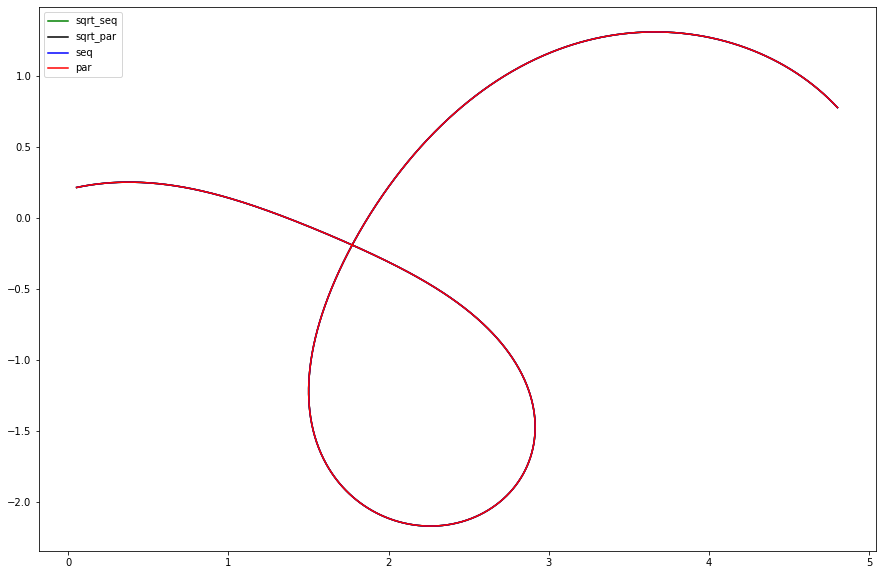

In [8]:
plt.figure(figsize=(15, 10))
plt.plot(sqrt_iterated_res_seq.mean[:,0], sqrt_iterated_res_seq.mean[:,1],'g', label = "sqrt_seq")
plt.plot(sqrt_iterated_res_par.mean[:,0], sqrt_iterated_res_par.mean[:,1],'k', label = "sqrt_par")
plt.plot(iterated_res_seq.mean[:,0], iterated_res_seq.mean[:,1],'b', label = "seq")
plt.plot(iterated_res_par.mean[:,0], iterated_res_par.mean[:,1],'r', label = "par")
plt.legend();



# Cubature

In [19]:
def cubature_std_seq(ys, initial_points, iteration):
    std_seq_res = iterated_smoothing(ys, init, transition_model, observation_model,
                                     cubature, initial_points, False,
                                     criterion=lambda i, *_: i < iteration)
    return std_seq_res


In [20]:
def cubature_std_par(ys, initial_points, iteration):
    std_par_res = iterated_smoothing(ys, init, transition_model, observation_model,
                                     cubature, initial_points, True,
                                     criterion=lambda i, *_: i < iteration)
    return std_par_res


In [21]:
def cubature_sqrt_seq(ys, initial_points_sqrt, iteration):
    sqrt_seq_res = iterated_smoothing(ys, chol_init, sqrt_transition_model, sqrt_observation_model,
                                      cubature, initial_points_sqrt, False,
                                      criterion=lambda i, *_: i < iteration)
    return sqrt_seq_res


In [22]:
def cubature_sqrt_par(ys, initial_points_sqrt, iteration):
    sqrt_par_res = iterated_smoothing(ys, chol_init, sqrt_transition_model, sqrt_observation_model,
                                      cubature, initial_points_sqrt, True,
                                      criterion=lambda i, *_: i < iteration)
    return sqrt_par_res


# Extended

In [23]:
def extended_std_seq(ys, initial_points, iteration):
    std_seq_res = iterated_smoothing(ys, init, transition_model, observation_model,
                                     extended, initial_points, False,
                                     criterion=lambda i, *_: i < iteration)
    return std_seq_res

In [24]:
def extended_std_par(ys, initial_points, iteration):
    std_par_res = iterated_smoothing(ys, init, transition_model, observation_model,
                                     extended, initial_points, True,
                                     criterion=lambda i, *_: i < iteration)
    return std_par_res

In [25]:
def extended_sqrt_seq(ys, initial_points_sqrt, iteration):
    sqrt_seq_res = iterated_smoothing(ys, chol_init, sqrt_transition_model, sqrt_observation_model,
                                      extended, initial_points_sqrt, False,
                                      criterion=lambda i, *_: i < iteration)
    return sqrt_seq_res

In [26]:
def extended_sqrt_par(ys, initial_points_sqrt, iteration):
    sqrt_par_res = iterated_smoothing(ys, chol_init, sqrt_transition_model, sqrt_observation_model,
                                      extended, initial_points_sqrt, True,
                                      criterion=lambda i, *_: i < iteration)
    return sqrt_par_res

# RunTime comparison

In [27]:
from jax import jit, devices, make_jaxpr
import time
from tqdm import tqdm

In [28]:
#std-cubature
cpu_cubature_std_seq = jit(cubature_std_seq, backend="cpu")
gpu_cubature_std_seq = jit(cubature_std_seq, backend="gpu")

cpu_cubature_std_par = jit(cubature_std_par, backend="cpu")
gpu_cubature_std_par = jit(cubature_std_par, backend="gpu")

#sqrt cubature
cpu_cubature_sqrt_seq = jit(cubature_sqrt_seq, backend="cpu")
gpu_cubature_sqrt_seq = jit(cubature_sqrt_seq, backend="gpu")

cpu_cubature_sqrt_par = jit(cubature_sqrt_par, backend="cpu")
gpu_cubature_sqrt_par = jit(cubature_sqrt_par, backend="gpu")

############################################################

#std extended
cpu_extended_std_seq = jit(extended_std_seq, backend="cpu")
gpu_extended_std_seq = jit(extended_std_seq, backend="gpu")

cpu_extended_std_par = jit(extended_std_par, backend="cpu")
gpu_extended_std_par = jit(extended_std_par, backend="gpu")

#sqrt extended
cpu_extended_sqrt_seq = jit(extended_sqrt_seq, backend="cpu")
gpu_extended_sqrt_seq = jit(extended_sqrt_seq, backend="gpu")

cpu_extended_sqrt_par = jit(extended_sqrt_par, backend="cpu")
gpu_extended_sqrt_par = jit(extended_sqrt_par, backend="gpu")

In [29]:
def profile_smoother(s_method, lengths, n_runs=1, n_iter=10, sqrt=False):
    res_mean = []
    for j in tqdm(lengths):
        observations_slice = ys[:j]
        
        if sqrt:
            init_linearizations_points_slice = initial_states_sqrt.mean[:j+1]
            init_linearizations_chols_slice = initial_states_sqrt.chol[:j+1]
            init_linearizations_states = MVNSqrt(init_linearizations_points_slice, init_linearizations_chols_slice)
            args = observations_slice, init_linearizations_states, n_iter
        else:
            init_linearizations_points_slice = initial_states.mean[:j+1]
            init_linearizations_covs_slice = initial_states.cov[:j+1]
            init_linearizations_states = MVNStandard(init_linearizations_points_slice, init_linearizations_covs_slice)
            args = observations_slice, init_linearizations_states, n_iter
            
        s = s_method(*args)                
        s.mean.block_until_ready()
        run_times = []
        for _ in range(n_runs):
            tic = time.time()
            s_states = s_method(*args)
            s_states.mean.block_until_ready()
            toc = time.time()
            run_times.append(toc - tic)
        res_mean.append(np.mean(run_times))
    return np.array(res_mean)



In [30]:
lengths_space = np.logspace(1, np.log10(T), num=20).astype(np.int32)


# CPU

In [27]:
# # CPU

# cpu_cubature_std_seq_time = profile_smoother(cpu_cubature_std_seq, lengths_space, sqrt = False)
# cpu_cubature_std_par_time = profile_smoother(cpu_cubature_std_par, lengths_space, sqrt = False)

# cpu_cubature_sqrt_seq_time = profile_smoother(cpu_cubature_sqrt_seq, lengths_space, sqrt = True)
# cpu_cubature_sqrt_par_time = profile_smoother(cpu_cubature_sqrt_par, lengths_space, sqrt = True)


# cpu_extended_std_seq_time = profile_smoother(cpu_extended_std_seq, lengths_space, sqrt = False)
# cpu_extended_std_par_time = profile_smoother(cpu_extended_std_par, lengths_space, sqrt = False)

# cpu_extended_sqrt_seq_time = profile_smoother(cpu_extended_sqrt_seq, lengths_space, sqrt = True)
# cpu_extended_sqrt_par_time = profile_smoother(cpu_extended_sqrt_par, lengths_space, sqrt = True)

In [34]:
cpu_cubature_std_seq_time = profile_smoother(cpu_cubature_std_seq, lengths_space, sqrt = False)
cpu_cubature_std_par_time = profile_smoother(cpu_cubature_std_par, lengths_space, sqrt = False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [19:20<00:00, 58.04s/it]


In [18]:
cpu_cubature_sqrt_seq_time = profile_smoother(cpu_cubature_sqrt_seq, lengths_space, sqrt = True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:08<00:00,  6.41s/it]


In [31]:
cpu_cubature_sqrt_par_time = profile_smoother(cpu_cubature_sqrt_par, lengths_space, sqrt = True)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [23:19<00:00, 69.97s/it]


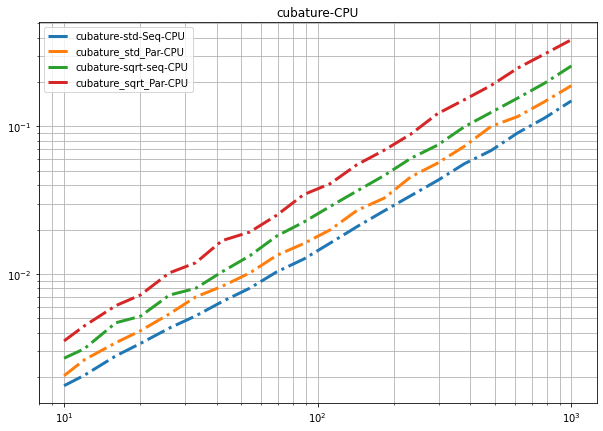

In [37]:

plt.figure(figsize=(10,7))
plt.loglog(lengths_space, cpu_cubature_std_seq_time, label="cubature-std-Seq-CPU", linestyle="-.", linewidth=3)
plt.loglog(lengths_space, cpu_cubature_std_par_time, label="cubature_std_Par-CPU", linestyle="-.", linewidth=3)
plt.loglog(lengths_space, cpu_cubature_sqrt_seq_time, label="cubature-sqrt-seq-CPU", linestyle="-.", linewidth=3)
plt.loglog(lengths_space, cpu_cubature_sqrt_par_time, label="cubature_sqrt_Par-CPU", linestyle="-.", linewidth=3)
plt.grid(True, which="both")
plt.title("cubature-CPU")
plt.legend()
plt.show()


In [47]:
jnp.savez("CPU-cubature-time",
          cpu_cubature_std_seq_time=cpu_cubature_std_seq_time,
          cpu_cubature_std_par_time=cpu_cubature_std_par_time,
          cpu_cubature_sqrt_seq_time=cpu_cubature_sqrt_seq_time,
          cpu_cubature_sqrt_par_time=cpu_cubature_sqrt_par_time)

In [41]:
import pandas as pd
data = np.stack([
                 cpu_cubature_std_seq_time,
                 cpu_cubature_std_par_time,
                 cpu_cubature_sqrt_seq_time,
                 cpu_cubature_sqrt_par_time],
                 axis=1)

columns = ["cpu_cubature_std_seq",
           "cpu_cubature_std_par",
           "cpu_cubature_sqrt_seq",
           "cpu_cubature_sqrt_par"]

df = pd.DataFrame(index=lengths_space, data=data, columns=columns)
df.to_csv("...")

# GPU

In [ ]:
# GPU
gpu_cubature_std_seq_time = profile_smoother(gpu_cubature_std_seq, lengths_space, sqrt = False)
gpu_cubature_std_par_time = profile_smoother(gpu_cubature_std_par, lengths_space, sqrt = False)

gpu_cubature_sqrt_seq_time = profile_smoother(gpu_cubature_std_par, lengths_space, sqrt = True)
gpu_cubature_sqrt_par_time = profile_smoother(gpu_cubature_std_par, lengths_space, sqrt = True)


gpu_extended_std_seq_time = profile_smoother(gpu_extended_std_seq, lengths_space, sqrt = False)
gpu_extended_std_par_time = profile_smoother(gpu_extended_std_par, lengths_space, sqrt = False)

gpu_extended_sqrt_seq_time = profile_smoother(gpu_extended_std_par, lengths_space, sqrt = True)
gpu_extended_sqrt_par_time = profile_smoother(gpu_extended_std_par, lengths_space, sqrt = True)

In [ ]:
jnp.savez("GPU-cubature-time",
          gpu_cubature_std_seq_time=gpu_cubature_std_seq_time,
          gpu_cubature_std_par_time=gpu_cubature_std_par_time,
          gpu_cubature_sqrt_seq_time=gpu_cubature_sqrt_seq_time,
          gpu_cubature_sqrt_par_time=gpu_cubature_sqrt_par_time)

In [ ]:
jnp.savez("GPU-extended-time",
          gpu_extended_std_seq_time=gpu_extended_std_seq_time,
          gpu_extended_std_par_time=gpu_extended_std_par_time,
          gpu_extended_sqrt_seq_time=gpu_extended_sqrt_seq_time,
          gpu_extended_sqrt_par_time=gpu_extended_sqrt_par_time)

In [ ]:
plt.figure(figsize=(10,7))
plt.loglog(lengths_space, gpu_cubature_std_seq_time, label="cubature-std-Seq-GPU", linestyle="-.", linewidth=3)
plt.loglog(lengths_space, gpu_cubature_std_par_time, label="cubature_std_Par-GPU", linestyle="-.", linewidth=3)
plt.loglog(lengths_space, gpu_cubature_sqrt_seq_time, label="cubature-sqrt-seq-GPU", linestyle="-.", linewidth=3)
plt.loglog(lengths_space, gpu_cubature_sqrt_par_time, label="cubature_sqrt_Par-GPU", linestyle="-.", linewidth=3)
plt.grid(True, which="both")
plt.title("cubature-GPU")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,7))
plt.loglog(lengths_space, gpu_extended_std_seq_time, label="extended-std-Seq-GPU", linestyle="-.", linewidth=3)
plt.loglog(lengths_space, gpu_extended_std_par_time, label="extended_std_Par-GPU", linestyle="-.", linewidth=3)
plt.loglog(lengths_space, gpu_extended_sqrt_seq_time, label="extended-sqrt-seq-GPU", linestyle="-.", linewidth=3)
plt.loglog(lengths_space, gpu_extended_sqrt_par_time, label="extended_sqrt_Par-GPU", linestyle="-.", linewidth=3)
plt.grid(True, which="both")
plt.title("extended-GPU")
plt.legend()
plt.show()